In [5]:
import sympy as sy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import librosa
import librosa.display

from librosa.feature import chroma_stft
from scipy.stats import ttest_ind

In [6]:
class AudioAnalyzer:
  def __init__(self, path, fft_size=512, sr=22050, analyze=True): # recommended value, fft_size & sampling rate
    y, sr = librosa.load(path, sr=sr)
    self.y = y
    self.sr = sr
    self.fft_size = fft_size
    if analyze:
      self.analysis()
  
  def analysis(self):
    # The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
    # np.abs is the magnitude of frequency bin f at frame t.
    self.df = pd.DataFrame(np.abs(librosa.stft(self.y, n_fft=self.fft_size))) 
    bins = librosa.fft_frequencies(sr=self.sr, n_fft=self.fft_size)
    self.df["bins"] = bins / 1000 # divide by 1000 lets us display in kHz
    self.df['average_amplitude'] = self.df.mean(axis=1)
    self.df = self.df[['bins', 'average_amplitude']]
    return self.df

  def plot_spectrum(self, min_freq=0, max_freq=None, fill=False, title="Spectrogram - Average Frequency"):
    # its values are sclaed by divide lets us display in kHz
    max_freq = max_freq or 20000
    window = self.df.loc[(self.df.bins * 1000. >= min_freq) & (self.df.bins * 1000. <= max_freq)].copy()
    # its values are scaled by interp lets us display in 0-1.
    window['scaled_amplitude'] = np.interp(window.average_amplitude, (0., max(window.average_amplitude)), (0., 1.))
    window.plot(x='bins', y='scaled_amplitude', figsize=(16,4))
    if fill:            
        plt.fill_between(self.df.bins, self.df.average_amplitude)
    
    legend = plt.legend()
    legend.remove()
    plt.xlabel("Frequency (kHz)", fontsize=20)
    plt.ylabel("Amplitude (scaled)", fontsize=20)
    plt.title(title, fontsize=26)

In [40]:
class AudioCompare:
  def __init__(self, reference, comparison):
    self.reference_df = reference.df
    self.comparison_df = comparison.df
    self.target = []

    self.dfs = [self.reference_df, self.comparison_df]

    self.get_max_average(self)
    self.scale_amplitudes(self)
    self.get_ratio_df(self)

  @staticmethod   
  def get_max_average(self):
      max_average = 0
      for df in self.dfs:
          cur_max = df.average_amplitude.max()
          max_average = cur_max if cur_max > max_average else max_average
      
      self.max_average = max_average
  
  @staticmethod
  def scale_amplitudes(self):        
      scaled_dfs = []
      for df in self.dfs:
          averaged = df['average_amplitude']
          df['scaled_amplitude'] = np.interp(averaged, (0., self.max_average), (0., 1.)) 
          scaled_dfs.append(df)            
      self.original_df, self.modified_df = scaled_dfs
      
  @staticmethod
  def get_ratio_df(self):
      
      orig_scaled = self.original_df.scaled_amplitude
      mod_scaled = self.modified_df.scaled_amplitude
      
      self.ratio_df = pd.DataFrame((mod_scaled - orig_scaled) + 0.5)
      self.ratio_df['bins'] = self.original_df.bins
      
      self.ratio_df.loc[self.ratio_df.scaled_amplitude > 1.0, ['scaled_amplitude']] = 1.0
      self.ratio_df.loc[self.ratio_df.scaled_amplitude < 0.0, ['scaled_amplitude']] = 0.0

  def plot_spectrum_group(self,
                          spectrum_1=True,
                          spectrum_2=True,
                          title="Comparison of Frequency Amplitudes",
                          xlabel="Frequency (kHz)",
                          ylabel="Scaled Amplitude",
                          frange=None,
                          ratio=False,
                          area=True,
                          legend=["Spectrum 1", "Spectrum 2", "Signal Difference", "Threshold"],
                          threshold=False):
    
    dfs = self.dfs.copy()
    fig = plt.figure(figsize=(16, 8))

    if frange:
        for i, df in enumerate(dfs):
            dfs[i] = df.loc[(df.bins * 1000. >= frange[0]) & (df.bins * 1000. <= frange[1])]
    else:
        dfs = self.dfs
    
    if spectrum_1: plt.plot(dfs[0].bins, dfs[0].scaled_amplitude, label=legend[0], c="steelblue")
    if spectrum_2: plt.plot(dfs[1].bins, dfs[1].scaled_amplitude, label=legend[1], c="coral")

    if ratio:
      area = 0
      for idx, row in self.ratio_df.iterrows():
        area += (row["scaled_amplitude"] * self.ratio_df['bins'][1])
      print("Amplitude Diff", area)
    
      if frange:                
          ratio_df = self.ratio_df[(self.ratio_df.bins * 1000. >= frange[0]) & (self.ratio_df.bins * 1000. <= frange[1])]
          plt.plot(ratio_df['bins'], ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen", linestyle="-.")
      else:
          plt.plot(self.ratio_df['bins'], self.ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen")

    if threshold and frange:
        plt.plot([frange[0] / 1000, frange[1] / 1000], [0.5, 0.5], linestyle="--", label=legend[3], c="r")
    
    if area:
      area_1 = 0
      for idx, row in self.dfs[0].iterrows():
        area_1 += (row["scaled_amplitude"] * self.ratio_df['bins'][1])
      print("English Audio:", area_1)
    
      area_2 = 0
      for idx, row in self.dfs[1].iterrows():
        area_2 += (row["scaled_amplitude"] * self.ratio_df['bins'][1])
      print("Korean Audio:", area_2)

    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20) 
    plt.legend(fontsize=14)

  def plot_spectrum_heatmap(self,
                            plot_spectrum=True,
                            frange=[],
                            title="Audio Comparison",
                            cmap="plasma",
                            background_color="white",
                            background_alpha=0.5
                            ):
    if plot_spectrum:
      df = self.reference_df
    else:
      df = self.comparison_df
    
    df["ratio_amplitude"] = self.ratio_df.scaled_amplitude

    df['attenuated_scaled'] = df.scaled_amplitude
    df['boosted_scaled'] = df.scaled_amplitude

    if len(frange):
        plot_df = df.loc[(df.bins >= frange[0] / 1000) & (df.bins <= frange[1] / 1000)]
        ratio_df = self.ratio_df.loc[(self.ratio_df.bins >= frange[0] / 1000) & (self.ratio_df.bins <= frange[1] / 1000)] 
    else:
        plot_df = df
        ratio_df = self.ratio_df

    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(211, facecolor="white")
    ax2 = fig.add_subplot(211, facecolor="#00000000")
    cbaxes = plt.subplot2grid((16,1), (10,0)) 
    cbaxes.set_title("Scaled Amplitude Ratio", size=14)
    
    sns.heatmap(data=ratio_df.set_index('bins').transpose(), cbar=True, cbar_ax=cbaxes, cbar_kws={"orientation" : "horizontal"}, cmap=cmap, alpha=0.95, zorder=1, ax=ax1, vmin=0.0, vmax=1.0)
    ax1.set_xlabel("")
    ax1.set_xticks([])
    ax1.set_ylabel("")
    ax1.set_yticks([])

    sns.lineplot(data=plot_df, x="bins", y="scaled_amplitude", color='black', zorder=10, ax=ax2, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
    ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, color='white', alpha=0.0)
    ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, y2=1.0, color=background_color, alpha=background_alpha)

    ax2.set_xlabel("Frequency (kHz)", size=28)
    ax2.set_ylabel("Scaled Amplitude", size=28)     
    
    ax2.margins(0)
    fig.suptitle(title, size=36, y=0.95)
    
  def plot_amplitude_distributions(self, 
                                n=10000, 
                                size=1000,
                                title="Amplitude Distributions",
                                xlabel="Average Amplitude (unscaled)",
                                ylabel="Density"
                                ):
    amp1 = self.dfs[0].scaled_amplitude
    amp2 = self.dfs[1].scaled_amplitude

    samples_1 = []
    samples_2 = []

    for i in range(size):
        samples_1.append(np.random.choice(amp1, size=size).mean())
        samples_2.append(np.random.choice(amp2, size=size).mean())

    plt.figure(figsize=(8,6))

    sns.distplot(samples_1)
    sns.distplot(samples_2)

    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    t_stat, p_val = ttest_ind(samples_1, samples_2, equal_var=False)
    return pd.DataFrame([[t_stat, p_val]], columns=["T-Statistic", "P-Value"])


In [41]:
path_en = "./audio/english2_stella.mp3"
path_kr = "./audio/korean2_stella.mp3"

In [42]:
en, sr = librosa.load(path_en)
kr, sr = librosa.load(path_kr)

/Users/zaewoo/miniforge3/envs/workspace/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/zaewoo/miniforge3/envs/workspace/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/var/folders/j4/g1ty5k8d2_gfwhz7k__s54sm0000gn/T/ipykernel_12217/2570640584.py:2: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(en, sr)


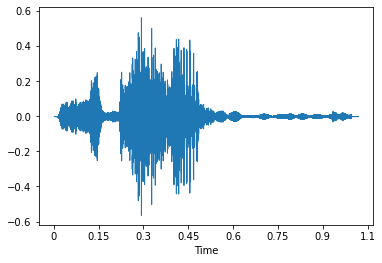

In [43]:
en = np.array(en)
librosa.display.waveshow(en, sr)

/var/folders/j4/g1ty5k8d2_gfwhz7k__s54sm0000gn/T/ipykernel_12217/3306218309.py:2: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(kr, sr)


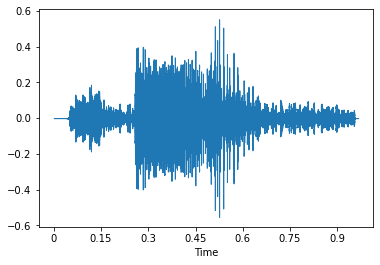

In [44]:
kr = np.array(kr)
librosa.display.waveshow(kr, sr)

/Users/zaewoo/miniforge3/envs/workspace/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


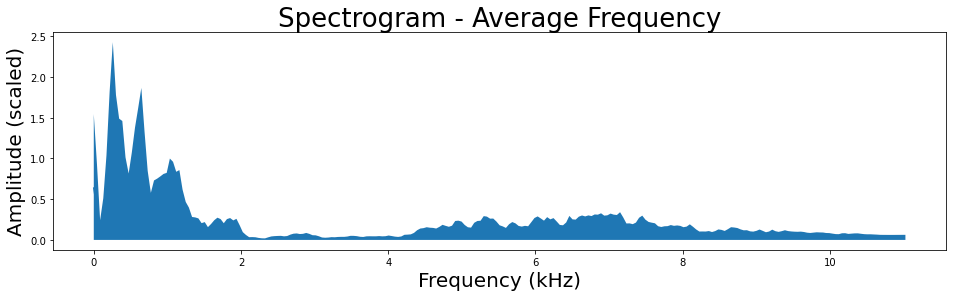

In [47]:
en = AudioAnalyzer("./audio/english2_stella.mp3")
en.plot_spectrum(min_freq=0, max_freq=1000, fill=True)

/Users/zaewoo/miniforge3/envs/workspace/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


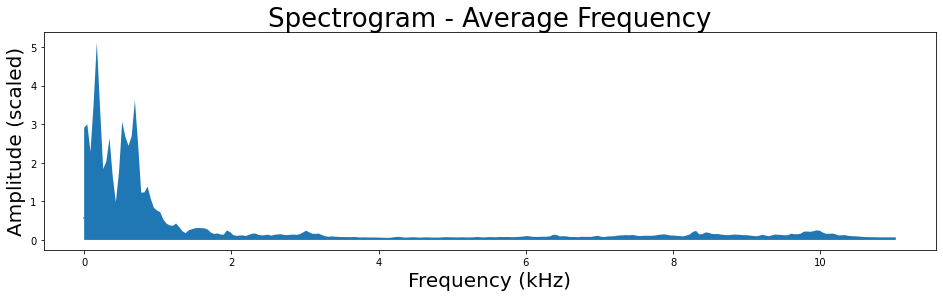

In [48]:
kr = AudioAnalyzer("./audio/korean2_stella.mp3")
kr.plot_spectrum(min_freq=0, max_freq=1000, fill=True)

In [49]:
en_kr = AudioCompare(en, kr)

English Audio: 0.5457576420463605
Korean Audio: 0.7052721642661627


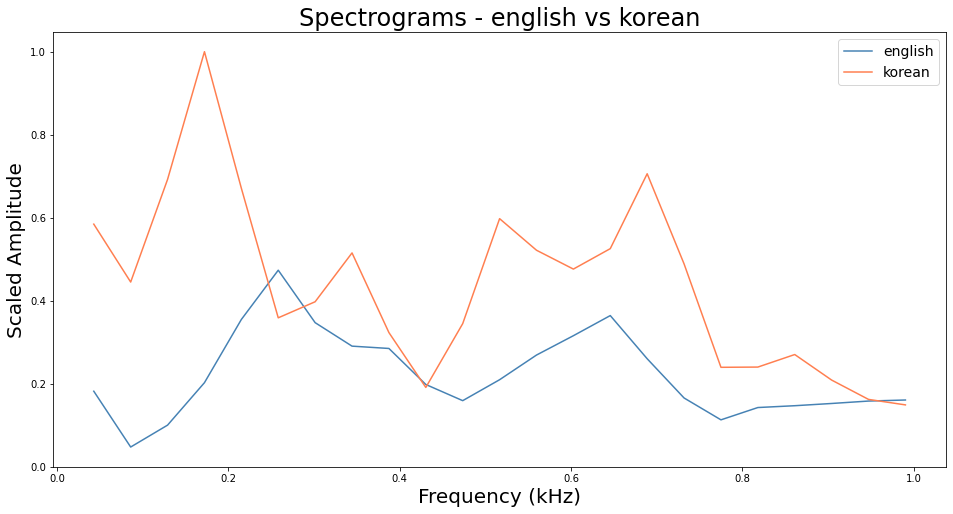

In [50]:
en_kr.plot_spectrum_group(    
    frange=(20,1000), 
    title="Spectrograms - english vs korean", 
    legend=("english", "korean")
    )

Amplitude Diff 5.676755154993781
English Audio: 0.5457576420463605
Korean Audio: 0.7052721642661627


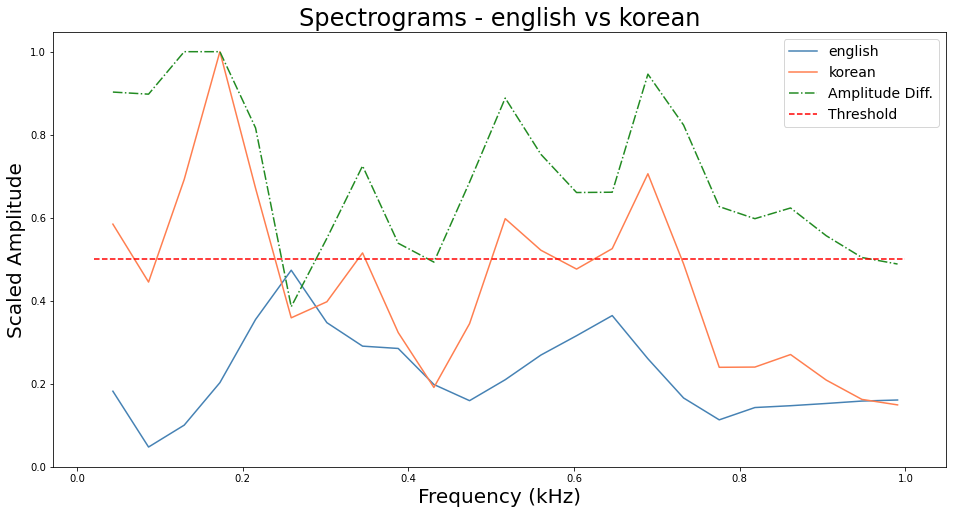

In [51]:
en_kr.plot_spectrum_group(
    frange=(20,1000), 
    ratio=True, 
    threshold=True,
    title="Spectrograms - english vs korean", 
    legend=("english", "korean", "Amplitude Diff.", "Threshold")
    )

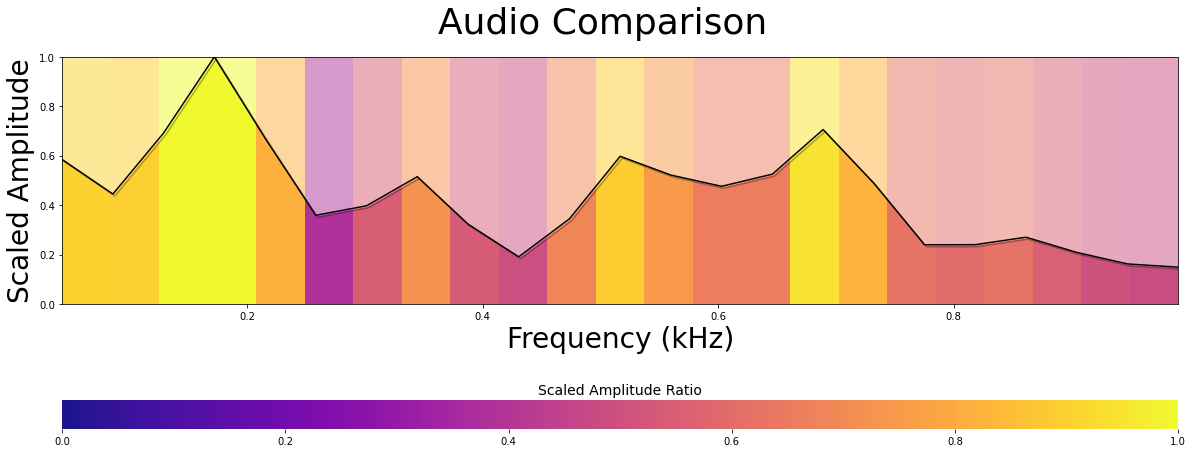

In [52]:
en_kr.plot_spectrum_heatmap(
    frange=(20,1000), 
    plot_spectrum=False
    )

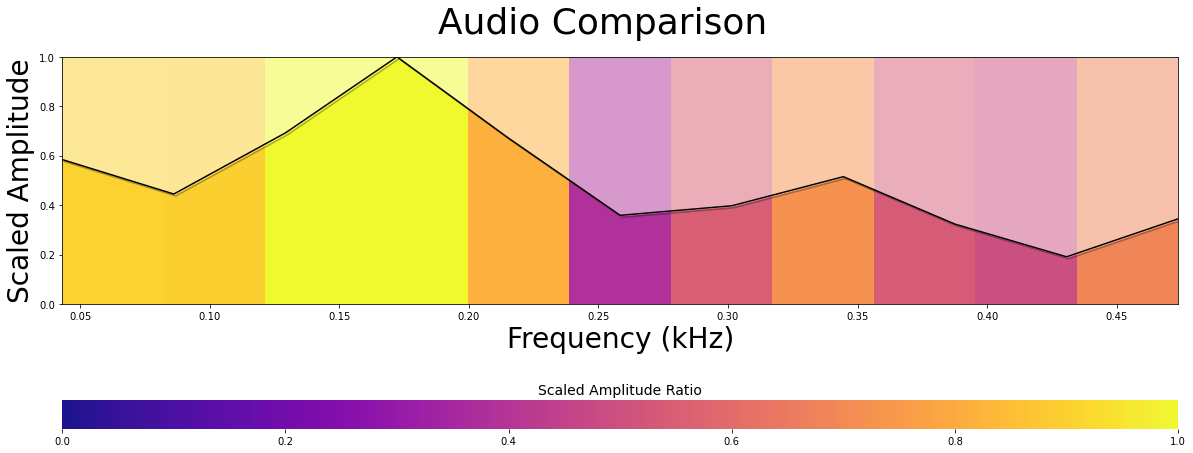

In [53]:
en_kr.plot_spectrum_heatmap(
    frange=(20,500), 
    plot_spectrum=False
    )